### Import Model Architectures
Custom Torch Models need to be instantiated for evaluation. The model_architectures.py file contains the model architectures so we can abstract it and focus only on the evaluations.

In [1]:
from model_architectures import *
import model_architectures
from attacks import * 
# Print available classes to verify our model architectures were imported
print(dir(model_architectures))

Using device: cuda
Using device: cuda
['BasicBlock', 'DataLoader', 'F', 'Load', 'ResNetCIFAR', 'ResNetMNIST', 'ResnetSVHN', 'TensorDataset', 'Tester', 'Visualizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'cifar_directory', 'conv3x3', 'current_directory', 'device', 'mnist_directory', 'nn', 'np', 'os', 'pd', 'pickle', 'plt', 'scipy', 'svhn_directory', 'torch']


### Loading the Model Weights
Using our model artifacts we load the weights back into the model so we have our pre-trained models to test our perturbations against.

In [2]:
mnist_resnet_model = ResNetMNIST(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=True).to(device)
cifar_resnet_model = ResNetCIFAR(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)
svhn_resnet_model = ResnetSVHN(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)

#add map_location=torch.device('cpu') if running locally and ur not sai lol
device = 'cuda'
# mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth", map_location=torch.device(device)))
# cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth", map_location=torch.device(device)))
# svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth",map_location=torch.device(device)))
mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth"))
cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth"))
svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth"))

<All keys matched successfully>

In [3]:
# Set models to evaluation mode
mnist_resnet_model.eval()
cifar_resnet_model.eval()
svhn_resnet_model.eval()

ResnetSVHN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [4]:
# Loading Data
loader = Load()
mnist_test_images, mnist_test_labels = loader.load_mnist_test_images()
cifar10_test_images, cifar10_test_labels = loader.load_cifar10_test_images()
svhn_test_images, svhn_test_labels = loader.load_svhn_test_images()

In [5]:
test_loader_mnist = loader.convert_mnist_numpy_to_tensor(mnist_test_images[:256], mnist_test_labels[:256])
test_loader_cifar10 = loader.convert_cifar10_numpy_to_tensor(cifar10_test_images[:256], cifar10_test_labels[:256])
test_loader_svhn = loader.convert_svhn_numpy_to_tensor(svhn_test_images[:256], svhn_test_labels[:256])
tester = Tester()

### DeepFool
The `deepfool_attack` function is designed to generate adversarial examples using the DeepFool algorithm. It iteratively picks the classified label closest to the true label that isn't the true label and then uses the gradient to move the image closer to that classification boundary while retaining image data as much as possible. It is considered a "perfect" algorithm as it terminates when the image misclassifies but we limit resources because this could take unreasonable amounts of time in theory. 

\begin{array}{l}
\textbf{while } sign(f(x_i)) = sign(f(x_0)): \\
\hspace{2em} r_i = - \frac{f(x_i)}{\|\nabla f(x_i)\|_2^2} \cdot \nabla f(x) \\
\hspace{2em} x_{i+1} = x_i + r_i \\
\hspace{2em} i = i + 1
\end{array}

Deepfool uses $L^2$ Norm Perturbations


In [6]:
def test_deepfool(model, test_loader, overshoot=0.02):
    correct = 0
    total = 0

    adv_examples = []
    batch = 0
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        batch += 1
        print(f"Batch: {batch}, Correct: {correct}")
        for image, label in zip(images, labels):
            print("image number: ",total)
            image = image.unsqueeze(0)
            label = label.unsqueeze(0)
            image.requires_grad = True
            output, _ = model(image)

            # print(outputs)

            _, init_pred = torch.max(output.data, 1)

            if not torch.equal(init_pred, label):
                total +=1 
                continue
            
            perturbed_image, final_pred, r_total, iter = deepfool_attack(image, model, overshoot=0.02, max_iterations=100)
            # print(f"Perturbed Iteration: {iter}")
            if torch.equal(final_pred, label):
                correct += 1
            else:
                adv_ex = perturbed_image.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            total +=1 
            

    accuracy = correct / total
    print(f"Test Accuracy = {correct} / {total} = {accuracy}")
    return accuracy, adv_examples

In [7]:
# MNIST
accuracy, examples = test_deepfool(mnist_resnet_model, test_loader_mnist)


Batch: 1, Correct: 0
image number:  0
image number:  1
image number:  2
image number:  3
image number:  4
image number:  5
image number:  6
image number:  7
image number:  8
image number:  9
image number:  10
image number:  11
image number:  12
image number:  13
image number:  14
image number:  15
image number:  16
image number:  17
image number:  18
image number:  19
image number:  20
image number:  21
image number:  22
image number:  23
image number:  24
image number:  25
image number:  26
image number:  27
image number:  28
image number:  29
image number:  30
image number:  31
image number:  32
image number:  33
image number:  34
image number:  35
image number:  36
image number:  37
image number:  38
image number:  39
image number:  40
image number:  41
image number:  42
image number:  43
image number:  44
image number:  45
image number:  46
image number:  47
image number:  48
image number:  49
image number:  50
image number:  51
image number:  52
image number:  53
image number:  54

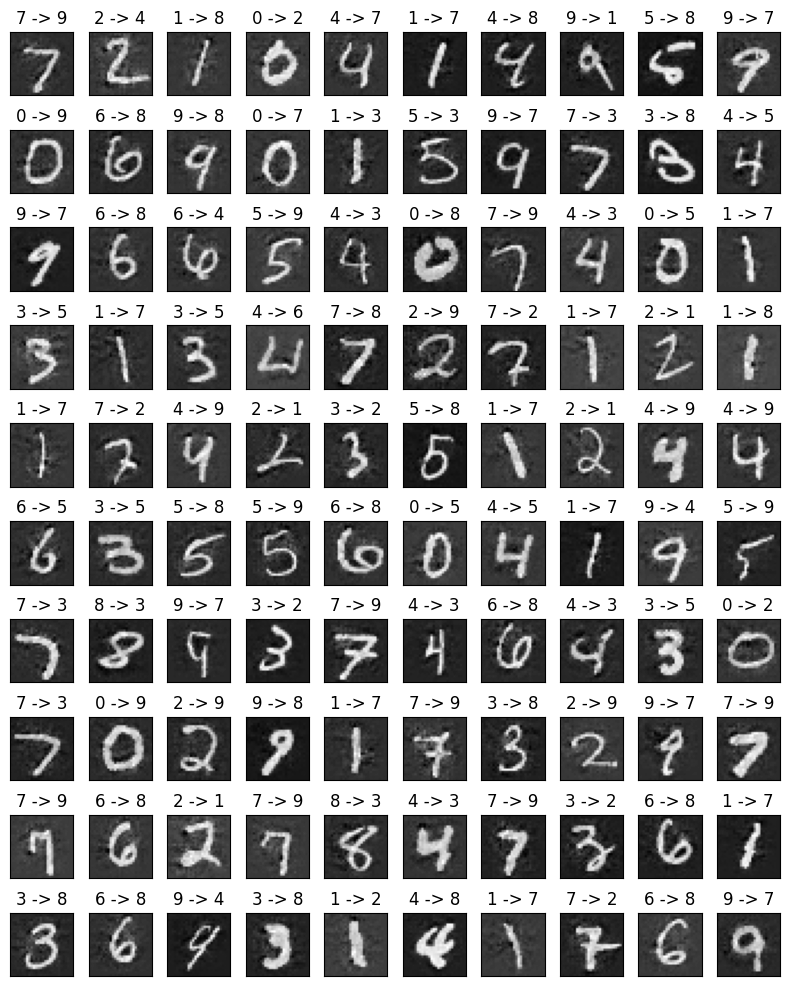

In [8]:
# MNIST Viewer
plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = examples[j]
    plt.title(f"{orig} -> {adv}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [9]:
# CIFAR10
accuracy, examples = test_deepfool(cifar_resnet_model, test_loader_cifar10)

Batch: 1, Correct: 0
image number:  0
image number:  1
image number:  2
image number:  3
image number:  4
image number:  5
image number:  6
image number:  7
image number:  8
image number:  9
image number:  10
image number:  11
image number:  12
image number:  13
image number:  14
image number:  15
image number:  16
image number:  17
image number:  18
image number:  19
image number:  20
image number:  21
image number:  22
image number:  23
image number:  24
image number:  25
image number:  26
image number:  27
image number:  28
image number:  29
image number:  30
image number:  31
image number:  32
image number:  33
image number:  34
image number:  35
image number:  36
image number:  37
image number:  38
image number:  39
image number:  40
image number:  41
image number:  42
image number:  43
image number:  44
image number:  45
image number:  46
image number:  47
image number:  48
image number:  49
image number:  50
image number:  51
image number:  52
image number:  53
image number:  54

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

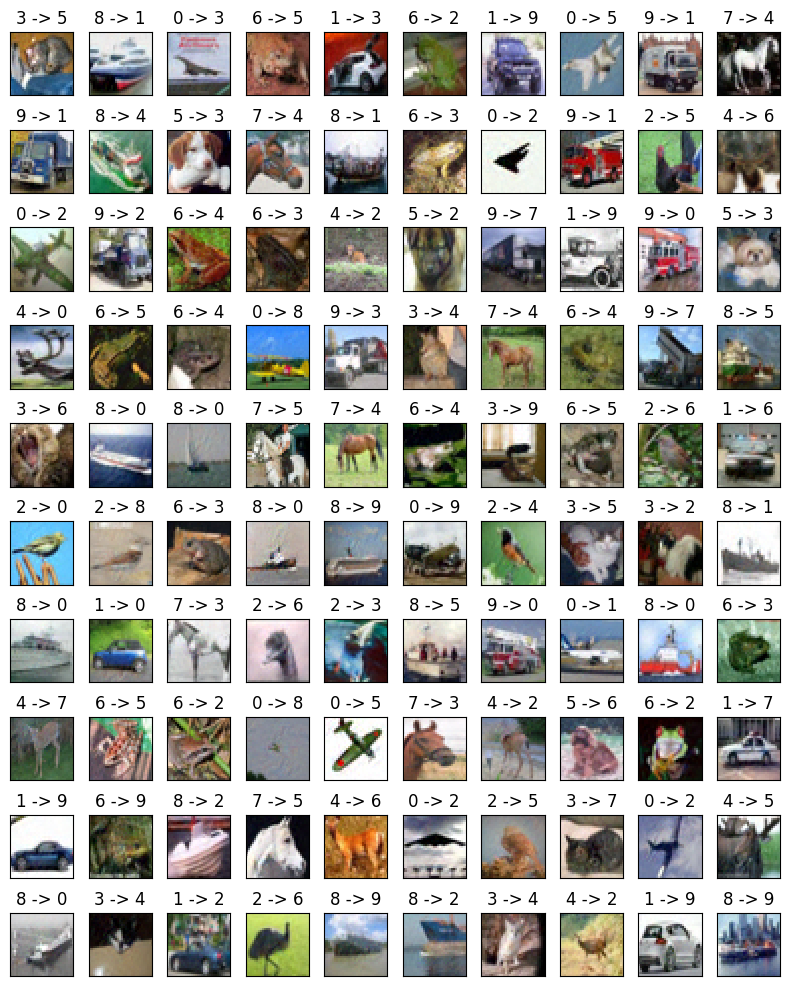

In [10]:
# CIFAR10/SVHN Viewer
plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    # ex = ex / 255.0  # Normalizing pixel values
    plt.title(f"{orig} -> {adv}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [11]:
# SVHN
accuracy, examples = test_deepfool(svhn_resnet_model, test_loader_svhn)

Batch: 1, Correct: 0
image number:  0
image number:  1
image number:  2
image number:  3
image number:  4
image number:  5
image number:  6
image number:  7
image number:  8
image number:  9
image number:  10
image number:  11
image number:  12
image number:  13
image number:  14
image number:  15
image number:  16
image number:  17
image number:  18
image number:  19
image number:  20
image number:  21
image number:  22
image number:  23
image number:  24
image number:  25
image number:  26
image number:  27
image number:  28
image number:  29
image number:  30
image number:  31
image number:  32
image number:  33
image number:  34
image number:  35
image number:  36
image number:  37
image number:  38
image number:  39
image number:  40
image number:  41
image number:  42
image number:  43
image number:  44
image number:  45
image number:  46
image number:  47
image number:  48
image number:  49
image number:  50
image number:  51
image number:  52
image number:  53
image number:  54

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

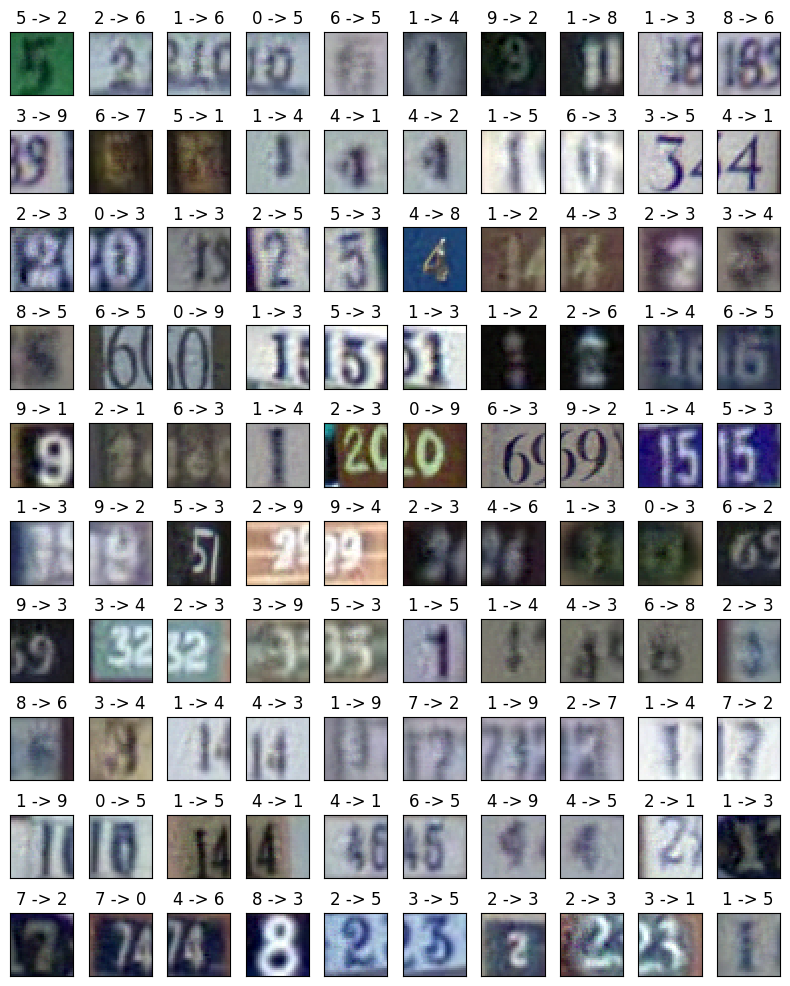

In [12]:
# CIFAR10/SVHN Viewer
plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    # ex = ex / 255.0  # Normalizing pixel values
    plt.title(f"{orig} -> {adv}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()